## Compare fitness function and EA 

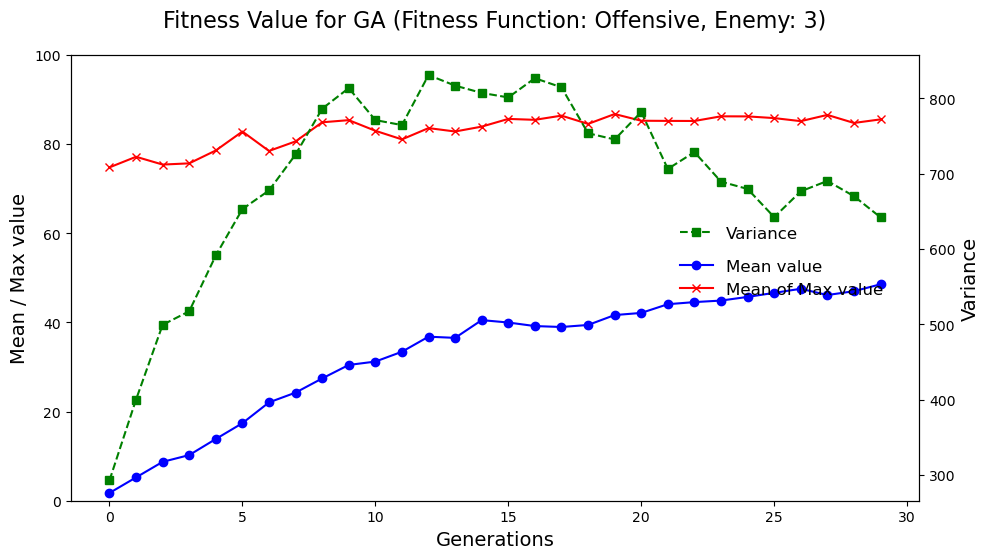

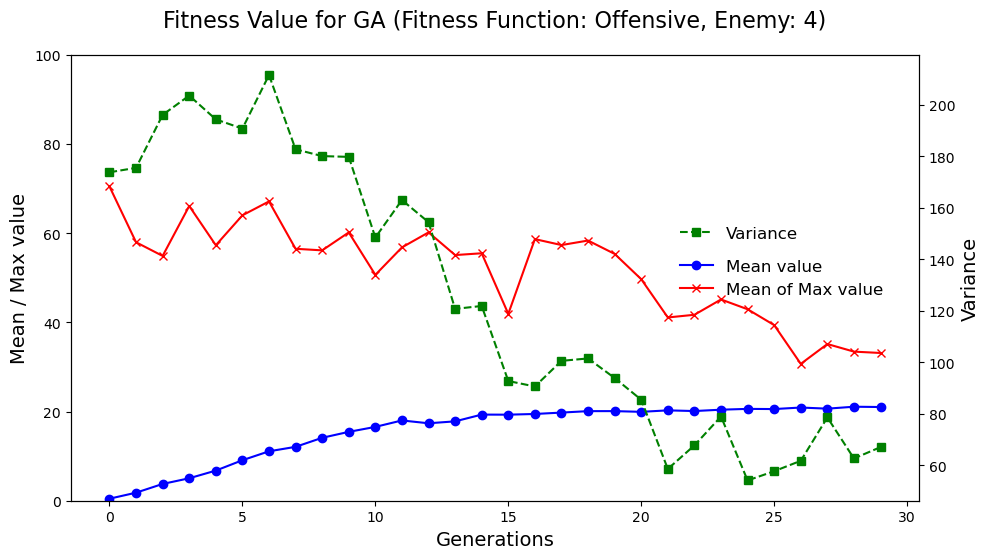

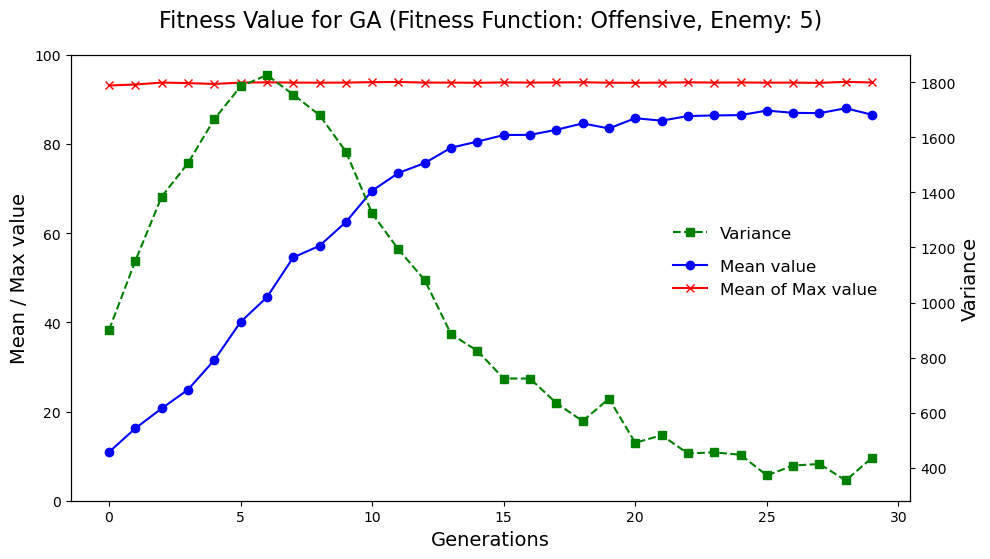

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define a function to plot the evolution of the specified metric (mean, variance, max)
def plot_fitness_evolution(EA_variable, fitness_mode, enemy, metric='fitness_values', fitness_function=''):
    base_folder = 'Group_96_data_for_plots'
    algorithm_folder = f"{base_folder}/{EA_variable}"
    fitness_folder = f"{algorithm_folder}/fitness_mode_{fitness_mode}"

    # Check if the folder exists
    if not os.path.exists(fitness_folder):
        raise FileNotFoundError(f"Folder {fitness_folder} does not exist.")
    
    # Store data for all run_ids across generations
    generations_data = [[] for _ in range(30)]  # Assuming 30 generations, adjust as needed

    # Loop through run1 to run10, reading data for each generation in each experiment
    for run_id in range(1, 11):  # Assuming 10 experiments
        # Now the run folder includes the enemy number
        run_folder = f"{fitness_folder}/enemy_{enemy}/run{run_id}"  # Updated directory for each enemy
        for generation in range(30):  # Assuming 30 generations
            gen_folder = f"{run_folder}/generation_{generation}_evaluation_enemy_{enemy}"
            metric_file = f"{gen_folder}/{metric}.txt"
            
            if not os.path.exists(metric_file):
                continue  # Skip this generation if the file does not exist
            
            # Read the metric data for each generation
            data = np.loadtxt(metric_file)
            generations_data[generation].append(data)
    
    # Prepare to store the mean, variance, and max for each generation
    means = []
    variances = []
    max_means = []

    # Compute the mean, variance, and mean of the max for each generation
    for generation_data in generations_data:
        # Concatenate all run_id data into one array
        generation_data_flat = np.concatenate(generation_data) if generation_data else np.array([])

        if generation_data_flat.size > 0:
            means.append(np.mean(generation_data_flat))
            variances.append(np.var(generation_data_flat))
            max_means.append(np.mean([np.max(run_data) for run_data in generation_data]))  # Mean of max per generation
        else:
            means.append(np.nan)
            variances.append(np.nan)
            max_means.append(np.nan)

    # Plot the evolution of mean, variance, and max across generations
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Set the left y-axis
    ax1.set_xlabel('Generations', fontsize=14)
    ax1.set_ylabel('Mean / Max value', fontsize=14)
    ax1.plot(range(30), means, marker='o', color='blue', label='Mean value')
    ax1.plot(range(30), max_means, marker='x', color='red', label='Mean of Max value')
    ax1.tick_params(axis='y')

    # Fix the y-axis range from 0 to 100 for Mean / Max value
    ax1.set_ylim(0, 100)

    # Set the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Variance', fontsize=14)
    ax2.plot(range(30), variances, marker='s', color='green', label='Variance', linestyle='--')
    ax2.tick_params(axis='y')

    # Set the plot title
    metric_label = 'Fitness Value' if metric == 'fitness_values' else 'Individual Gain'
    plt.title(f'{metric_label} for {EA_variable} (Fitness Function: {fitness_function}, Enemy: {enemy})', fontsize=16, pad=20)  # pad adds space between title and plot

    # Add legends and move them to the right side, vertically aligned in the center
    ax1.legend(loc='center left', bbox_to_anchor=(0.7, 0.5), frameon=False, fontsize=12)  # Place legend for ax1
    ax2.legend(loc='center left', bbox_to_anchor=(0.7, 0.6), frameon=False, fontsize=12)  # Place legend for ax2

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to prevent overlap

    # Include fitness_function in the file name
    file_name = f"{metric_label}_for_{EA_variable}_Fitness_{fitness_function}_Enemy_{enemy}".replace(' ', '_').replace(':', '')
    plt.savefig(f'Group_96_plots/{file_name}.png', bbox_inches='tight')
    plt.show()

# Example call
enemies = [3, 4, 5]
for fitness_mode in [1]:
    if fitness_mode == 1:
        fitness_function = "Offensive"
    else:
        fitness_function = "Survival"
    for enemy in enemies:
        # Plot the evolution of fitness_values
        #plot_fitness_evolution(EA_variable="DE", fitness_mode=fitness_mode, enemy=enemy, metric='fitness_values', fitness_function=fitness_function)

        # Plot the evolution of individual_gains
        plot_fitness_evolution(EA_variable="GA", fitness_mode=fitness_mode, enemy=enemy, metric='fitness_values', fitness_function=fitness_function)


## test

In [29]:
import os
import numpy as np
headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy" 
# Define a function to compute the mean of max values across runs
def compute_mean_of_max(EA_variable, fitness_mode, enemy, metric='fitness_values'):
    base_folder = 'Group_96_data_for_plots'
    algorithm_folder = f"{base_folder}/{EA_variable}"
    fitness_folder = f"{algorithm_folder}/fitness_mode_{fitness_mode}"

    # Check if the folder exists
    if not os.path.exists(fitness_folder):
        raise FileNotFoundError(f"Folder {fitness_folder} does not exist.")
    
    # List to store the max value from each run
    max_values = []

    # Loop through run1 to run10, reading the max value for each run
    for run_id in range(1, 11):  # Assuming 10 experiments
        run_folder = f"{fitness_folder}/enemy_{enemy}/run{run_id}"
        run_max_values = []

        # Loop through each generation for the current run
        for generation in range(30):  # Assuming 30 generations
            gen_folder = f"{run_folder}/generation_{generation}_evaluation_enemy_{enemy}"
            metric_file = f"{gen_folder}/{metric}.txt"
            
            if not os.path.exists(metric_file):
                continue  # Skip this generation if the file does not exist
            
            # Load the metric data
            data = np.loadtxt(metric_file)
            run_max_values.append(np.max(data))

        if run_max_values:
            max_values.append(np.max(run_max_values))  # Store the max of the maxes for this run
    
    # Compute and return the mean of the max values across all runs
    if max_values:
        return np.mean(max_values)
    else:
        return np.nan

# Example call
enemies = [3,4,5]
for enemy in enemies:
    mean_max_value = compute_mean_of_max(EA_variable="GA", fitness_mode=2, enemy=enemy, metric='fitness_values')
    print(f"Mean of max values for Enemy {enemy}: {mean_max_value}")


Mean of max values for Enemy 3: 55.56343011816291
Mean of max values for Enemy 4: 68.15037351745579
Mean of max values for Enemy 5: 88.55937213140007


## Calculate final best individual *5

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from evoman.environment import Environment
from demo_controller import player_controller
# 设置隐藏层神经元数
n_hidden_neurons = 10

headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy" 
    
# 读取神经网络权重
def load_best_individual(EA_variable, fitness_mode, enemy, run):
    base_folder = 'Group_96_data_for_plots'
    file_path = f"{base_folder}/{EA_variable}/fitness_mode_{fitness_mode}/enemy_{enemy}/run{run}/best_individual.txt"
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    return np.loadtxt(file_path)

# 模拟神经网络，返回 individual gain
def simulate_best_individual(EA_variable, fitness_mode, enemy, run):
    weights = load_best_individual(EA_variable, fitness_mode, enemy, run)
    experiment_name = "best_individual_simulation"
    
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False,
        randomini="yes"
    )
    
    fitness, player_energy, enemy_energy, time = env.play(pcont=weights)
    individual_gain = player_energy - enemy_energy
    return individual_gain

# 进行模拟并记录结果
def simulate_for_enemies(EA_variable, fitness_mode, runs=10, enemies=[3, 4, 5]):
    results = {}
    for enemy in enemies:
        enemy_results = []
        for run in range(1, runs + 1):
            for i in range(6):
                individual_gain = simulate_best_individual(EA_variable, fitness_mode, enemy, run)
                enemy_results.append(individual_gain)
        results[enemy] = enemy_results
    return results

# 模拟所有组合的结果，并储存到 all_results
def simulate_for_all_conditions(EA_variables, fitness_modes, runs=10, enemies=[3, 4, 5]):
    all_results = {}
    for EA_variable in EA_variables:
        for fitness_mode in fitness_modes:
            result_key = (EA_variable, fitness_mode)
            all_results[result_key] = simulate_for_enemies(EA_variable, fitness_mode, runs, enemies)
    return all_results

# 绘制 boxplot 的函数
def plot_boxplot_results(all_results, EA_variable, fitness_mode, metric='individual_gains'):
    result_key = (EA_variable, fitness_mode)
    results = all_results.get(result_key)

    if results is None:
        raise ValueError(f"No results found for EA_variable={EA_variable} and fitness_mode={fitness_mode}")

    # 将 results 字典转换为绘图数据格式
    data = []
    enemies = []
    
    # 打印每个 enemy 的 max, min, median, variance
    for enemy, values in results.items():
        max_value = np.max(values)
        min_value = np.min(values)
        median_value = np.median(values)
        variance_value = np.var(values)

        print(f"Enemy {enemy}:")
        print(f"  Max: {max_value}")
        print(f"  Min: {min_value}")
        print(f"  Median: {median_value}")
        print(f"  Variance: {variance_value}")
        print("-" * 30)
        
        # 将数据扩展以便用于绘图
        data.extend(values)
        enemies.extend([f"Enemy {enemy}"] * len(values))
    
    # 创建 DataFrame 来准备绘图
    df = pd.DataFrame({'Individual Gain': data, 'Enemy': enemies})
    
    # 绘制 Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Enemy', y='Individual Gain', data=df)
    plt.title(f'{metric} for Different Enemies (EA: {EA_variable}, Fitness Mode: {fitness_mode})', fontsize=16)
    plt.xlabel('Enemy')
    plt.ylabel('Individual Gain')
    plt.show()

# 示例调用：模拟所有组合
EA_variables = ["DE"]
fitness_modes = [1, 2]

# 运行模拟并存储所有结果
all_results = simulate_for_all_conditions(EA_variables, fitness_modes, runs=10, enemies=[3, 4, 5])



MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: 

Enemy 3:
  Max: 60.0
  Min: -50.0
  Median: -20.0
  Variance: 1114.5822222222223
------------------------------
Enemy 4:
  Max: 70.60000000000028
  Min: -90.0
  Median: 27.400000000000254
  Variance: 2439.245100000013
------------------------------
Enemy 5:
  Max: 98.80000000000001
  Min: -100.0
  Median: 81.40000000000018
  Variance: 1580.4857222222226
------------------------------


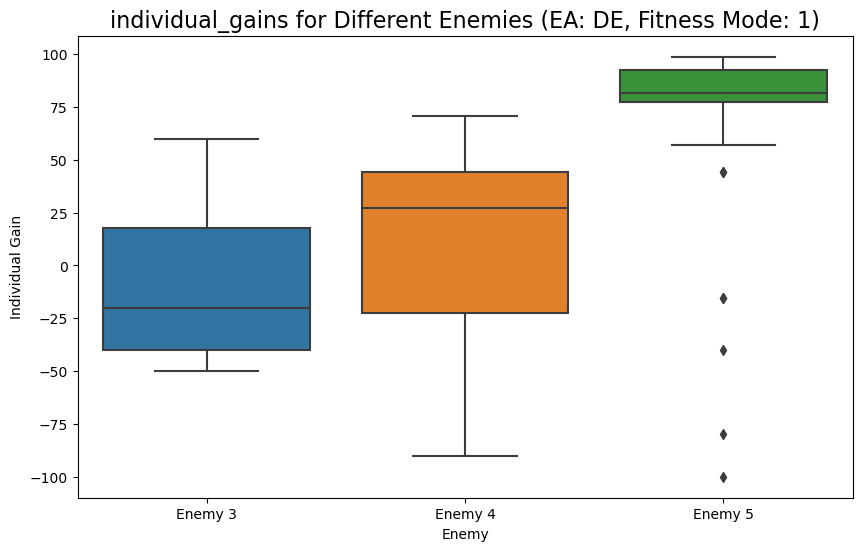

Enemy 3:
  Max: 66.0
  Min: -70.0
  Median: -20.0
  Variance: 1538.5822222222223
------------------------------
Enemy 4:
  Max: 80.20000000000019
  Min: -100.0
  Median: -40.0
  Variance: 3178.0068888888986
------------------------------
Enemy 5:
  Max: 98.20000000000002
  Min: -11.399999999999672
  Median: 88.60000000000011
  Variance: 859.8198222222198
------------------------------


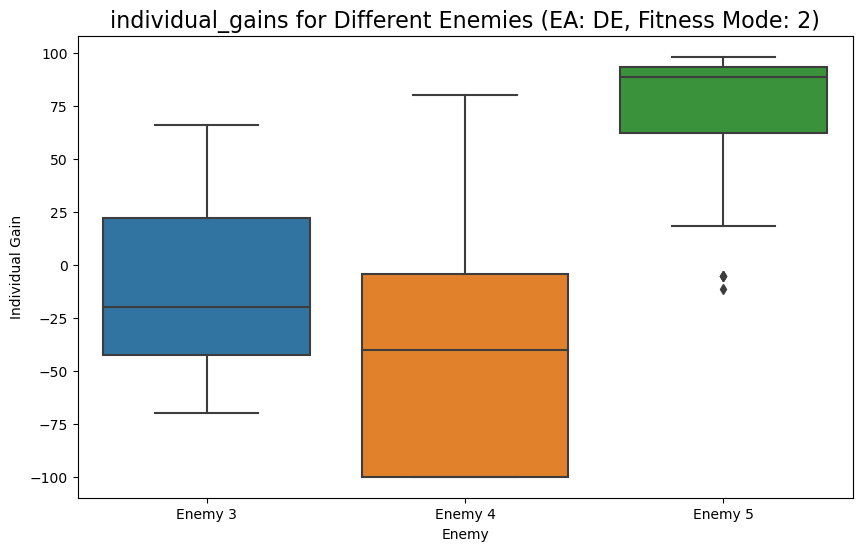

In [31]:
# 绘制特定 EA_variable 和 fitness_mode 的 boxplot
a = [1,2]
for fitness_mode in a:
    plot_boxplot_results(all_results, EA_variable="DE", fitness_mode=fitness_mode)

## Final part

## Learning process comparison

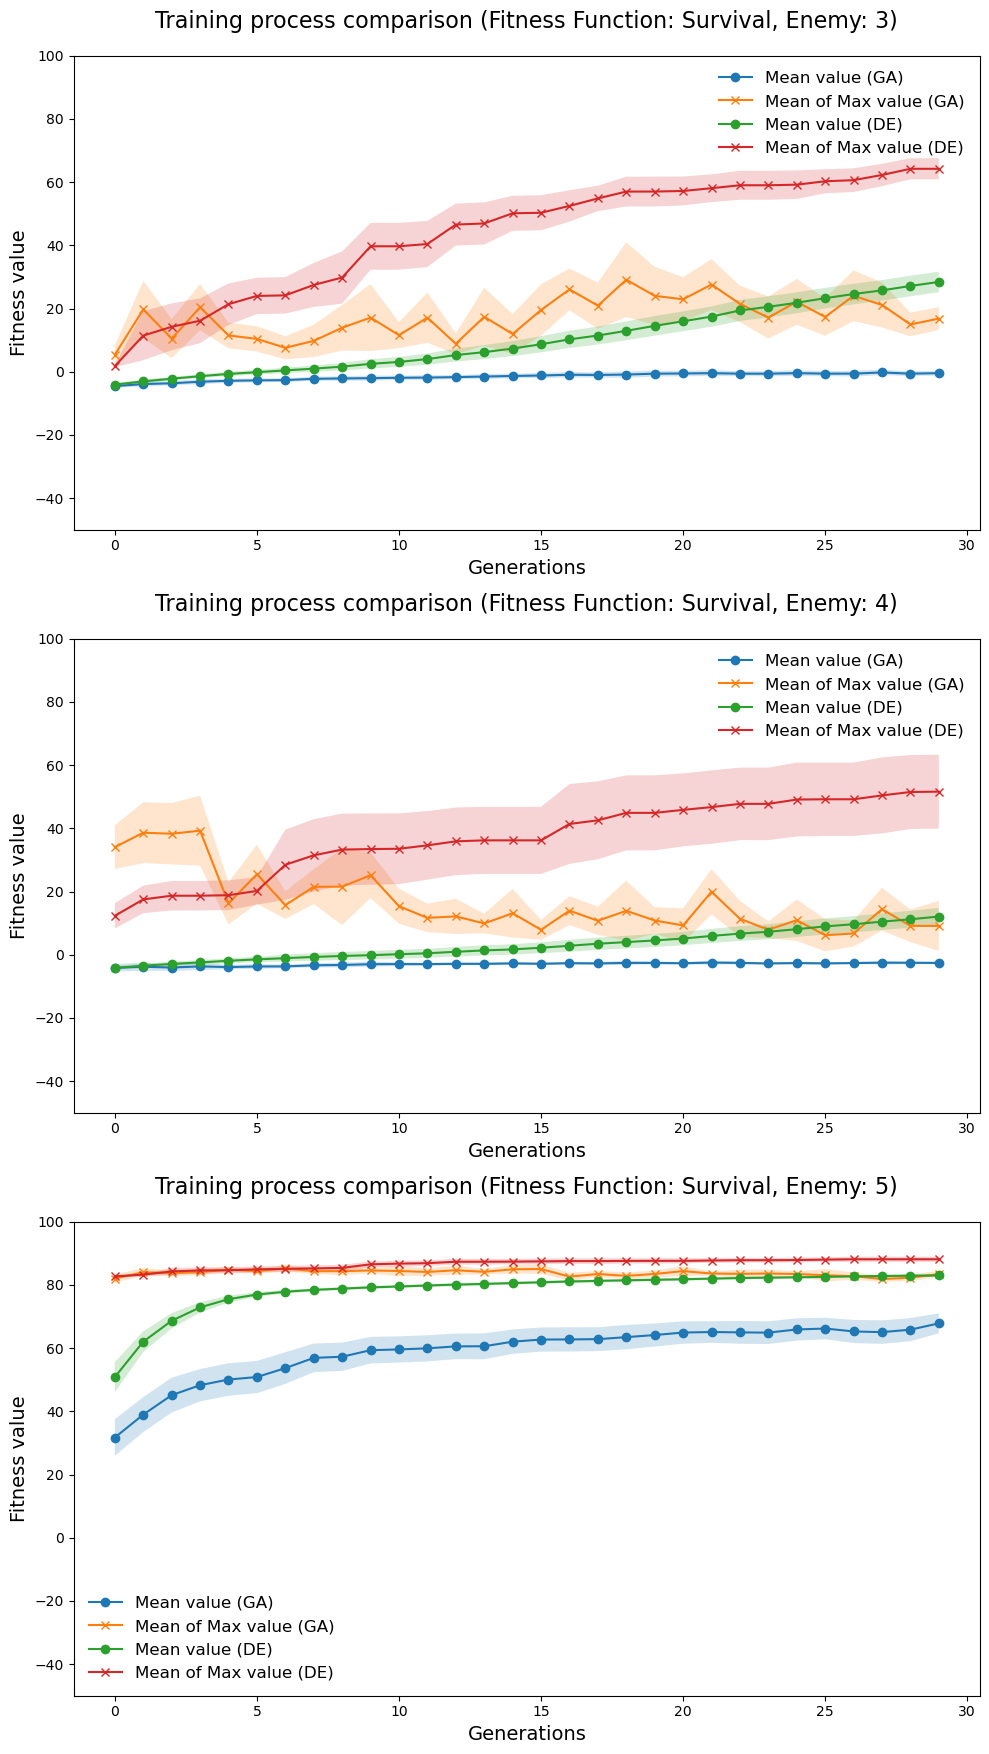

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define a function to plot the evolution of the specified metric (mean, standard deviation, max)
def plot_fitness_evolution(ax1, EA_variable, fitness_mode, enemy, metric='fitness_values', fitness_function=''):
    base_folder = 'Group_96_data_for_plots'
    algorithm_folder = f"{base_folder}/{EA_variable}"
    fitness_folder = f"{algorithm_folder}/fitness_mode_{fitness_mode}"

    # Check if the folder exists
    if not os.path.exists(fitness_folder):
        raise FileNotFoundError(f"Folder {fitness_folder} does not exist.")
    
    # Store data for all run_ids across generations
    generations_data = [[] for _ in range(30)]  # Assuming 30 generations, adjust as needed

    # Loop through run1 to run10, reading data for each generation in each experiment
    for run_id in range(1, 11):  # Assuming 10 experiments
        # Now the run folder includes the enemy number
        run_folder = f"{fitness_folder}/enemy_{enemy}/run{run_id}"  # Updated directory for each enemy
        for generation in range(30):  # Assuming 30 generations
            gen_folder = f"{run_folder}/generation_{generation}_evaluation_enemy_{enemy}"
            metric_file = f"{gen_folder}/{metric}.txt"
            
            if not os.path.exists(metric_file):
                continue  # Skip this generation if the file does not exist
            
            # Read the metric data for each generation
            data = np.loadtxt(metric_file)
            generations_data[generation].append(data)
    
    # Prepare to store the mean and standard deviation for each generation
    means = []
    mean_stds = []  # Standard deviation for Mean value
    max_means = []
    max_stds = []  # Standard deviation for Max value

    # Compute the mean, standard deviation, and mean of the max for each generation
    for generation_data in generations_data:
        # Concatenate all run_id data into one array
        generation_data_flat = np.concatenate(generation_data) if generation_data else np.array([])

        if generation_data_flat.size > 0:
            means.append(np.mean(generation_data_flat))
            mean_stds.append(np.std(generation_data_flat))  # Standard deviation of the Mean
            max_values = [np.max(run_data) for run_data in generation_data]  # Max values per run
            max_means.append(np.mean(max_values))
            max_stds.append(np.std(max_values))  # Standard deviation of the Max
        else:
            means.append(np.nan)
            mean_stds.append(np.nan)
            max_means.append(np.nan)
            max_stds.append(np.nan)

    # Plot Mean value with standard deviation as shaded region
    ax1.plot(range(30), means, marker='o', label=f'Mean value ({EA_variable})')
    ax1.fill_between(range(30), np.array(means) - 0.2 * np.array(mean_stds), np.array(means) + 0.2 * np.array(mean_stds), alpha=0.2)

    # Plot Mean of Max value with standard deviation as shaded region
    ax1.plot(range(30), max_means, marker='x', label=f'Mean of Max value ({EA_variable})')
    ax1.fill_between(range(30), np.array(max_means) - 0.5 * np.array(max_stds), np.array(max_means) + 0.5 * np.array(max_stds), alpha=0.2)

# Example call
enemies = [3, 4, 5]
metric='fitness_values'
fitness_mode = 2
fitness_function = "Offensive" if fitness_mode == 1 else "Survival"

# Create a figure with 3 subplots (one for each enemy)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))  # 3 rows, 1 column

# Loop through the enemies and create a plot for each
for i, enemy in enumerate(enemies):
    ax1 = axes[i]  # Select the appropriate subplot
    ax1.set_xlabel('Generations', fontsize=14)
    ax1.set_ylabel('Fitness value', fontsize=14)
    ax1.set_ylim(-50, 100)

    # Plot for EA_variable="GA"
    plot_fitness_evolution(ax1, EA_variable="GA", fitness_mode=fitness_mode, enemy=enemy, metric='fitness_values', fitness_function=fitness_function)

    # Plot for EA_variable="DE"
    plot_fitness_evolution(ax1, EA_variable="DE", fitness_mode=fitness_mode, enemy=enemy, metric='fitness_values', fitness_function=fitness_function)

    # Set the plot title for each subplot
    ax1.set_title(f'Training process comparison (Fitness Function: {fitness_function}, Enemy: {enemy})', fontsize=16, pad=20)

    # Add legends in the best position for each subplot
    ax1.legend(loc='best', frameon=False, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to prevent overlap

# Save the whole figure as one large image
file_name = f"Comparison_for_GA_DE_Fitness_{fitness_function}_All_Enemies".replace(' ', '_').replace(':', '')
plt.savefig(f'Group_96_plots/{file_name}.png', bbox_inches='tight')

# Show the plot
plt.show()


## Boxplot comparing Fitness functions

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import ttest_ind
from evoman.environment import Environment
from demo_controller import player_controller

# 设置隐藏层神经元数
n_hidden_neurons = 10

headless = True
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy" 
    
# 读取神经网络权重
def load_best_individual(EA_variable, fitness_mode, enemy, run):
    base_folder = 'Group_96_data_for_plots'
    file_path = f"{base_folder}/{EA_variable}/fitness_mode_{fitness_mode}/enemy_{enemy}/run{run}/best_individual.txt"
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    return np.loadtxt(file_path)

# 模拟神经网络，返回 individual gain
def simulate_best_individual(EA_variable, fitness_mode, enemy, run):
    weights = load_best_individual(EA_variable, fitness_mode, enemy, run)
    experiment_name = "best_individual_simulation"
    
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=[enemy],
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False,
        randomini="yes"
    )
    
    fitness, player_energy, enemy_energy, time = env.play(pcont=weights)
    individual_gain = player_energy - enemy_energy
    return individual_gain

# 进行模拟并记录结果
def simulate_for_enemies(EA_variable, fitness_mode, runs=10, enemies=[3, 4, 5]):
    results = {}
    for enemy in enemies:
        enemy_results = []
        for run in range(1, runs + 1):
            for i in range(5):
                individual_gain = simulate_best_individual(EA_variable, fitness_mode, enemy, run)
                enemy_results.append(individual_gain)
        results[enemy] = enemy_results
    return results

# 模拟所有组合的结果，并储存到 all_results
def simulate_for_all_conditions(EA_variables, fitness_modes, runs=10, enemies=[3, 4, 5]):
    all_results = {}
    for EA_variable in EA_variables:
        for fitness_mode in fitness_modes:
            result_key = (EA_variable, fitness_mode)
            all_results[result_key] = simulate_for_enemies(EA_variable, fitness_mode, runs, enemies)
    return all_results

# 示例调用：模拟所有组合
EA_variables = ["DE", "GA"]  # 假设有两个进化算法
fitness_modes = [1, 2]  # 两种适应度函数

# 运行模拟并存储所有结果
all_results = simulate_for_all_conditions(EA_variables, fitness_modes, runs=10, enemies=[3, 4, 5])



MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: Pygame initialized for simulation.

MESSAGE: 

### plot

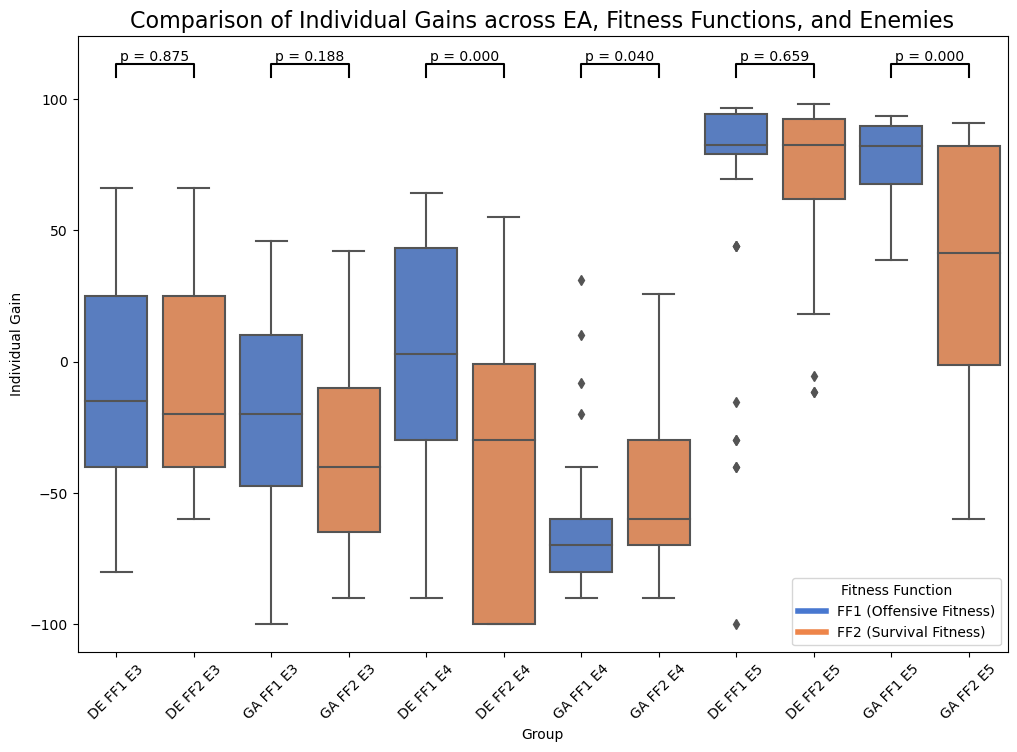

In [34]:
# 计算显著性水平（p值）并绘制 boxplot
def plot_boxplot_with_significance(all_results, EA_variables, enemies=[3, 4, 5]):
    # 收集所有数据以便绘图
    data = []
    labels = []
    color_palette = sns.color_palette("muted", 2)  # 为 FF1 和 FF2 指定不同的颜色
    
    for enemy in enemies:
        for (EA_variable, fitness_mode), result in all_results.items():
            gains = result[enemy]
            ff_label = "FF1" if fitness_mode == 1 else "FF2"
            labels.append(f"{EA_variable} {ff_label} E{enemy}")
            data.append(gains)

    # 创建 DataFrame 用于绘图
    df = pd.DataFrame({
        'Individual Gain': np.concatenate(data),
        'Group': np.concatenate([[label] * len(gains) for label, gains in zip(labels, data)])
    })
    
    plt.figure(figsize=(12, 8))
    
    # 颜色按 fitness function 分配，FF1使用第一个颜色，FF2使用第二个颜色
    box_colors = [color_palette[0] if 'FF1' in label else color_palette[1] for label in df['Group']]
    
    # 绘制 boxplot，使用自定义的颜色
    ax = sns.boxplot(x='Group', y='Individual Gain', data=df, palette=color_palette)
    
    plt.title('Comparison of Individual Gains across EA, Fitness Functions, and Enemies', fontsize=16)
    file_name = 'Comparison of Individual Gains across EA, Fitness Functions, and Enemies'
    plt.xticks(rotation=45)

    # 添加自定义图例，区分 FF1 和 FF2
    handles = [
        plt.Line2D([0], [0], color=color_palette[0], lw=4, label='FF1 (Offensive Fitness)'),
        plt.Line2D([0], [0], color=color_palette[1], lw=4, label='FF2 (Survival Fitness)'),
    ]
    plt.legend(handles=handles, title="Fitness Function", loc="best")  # 使用 loc="best" 来自动选择最佳位置
    
    # 只比较相同 EA 和相同敌人下的不同 fitness_mode 的差异
    unique_groups = df['Group'].unique()
    y_max = df['Individual Gain'].max()  # 用于定位 p 值显示位置

    for enemy in enemies:
        for EA_variable in EA_variables:
            group1_label = f"{EA_variable} FF1 E{enemy}"
            group2_label = f"{EA_variable} FF2 E{enemy}"

            if group1_label in unique_groups and group2_label in unique_groups:
                group1 = df[df['Group'] == group1_label]['Individual Gain']
                group2 = df[df['Group'] == group2_label]['Individual Gain']
                
                # 使用 t-test 计算p值
                t_stat, p_value = ttest_ind(group1, group2)

                # 设置两组数据在图中的x轴位置
                x1, x2 = list(unique_groups).index(group1_label), list(unique_groups).index(group2_label)
                y, h = y_max + 10, 5  # 设置 y 轴的显示位置和高度
                
                # 在两组boxplot之间绘制连接线并显示p值
                ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color='black')
                ax.text((x1 + x2) * 0.5, y + h, f"p = {p_value:.3f}", ha='center', va='bottom', color='black')
    plt.savefig(f'Group_96_plots/{file_name}.png', bbox_inches='tight')
    plt.show()

# 示例调用：绘制带有显著性水平的 boxplot
plot_boxplot_with_significance(all_results, EA_variables)


## Comparing EA

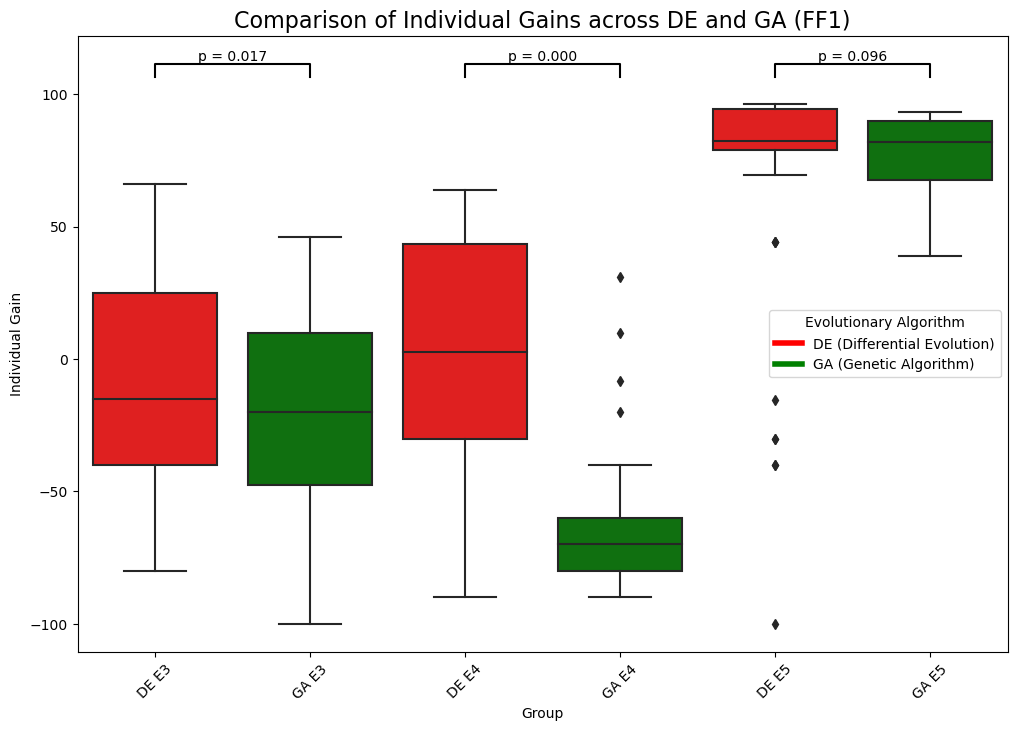

In [35]:
# 计算显著性水平（p值）并绘制 boxplot
def plot_boxplot_with_significance(all_results, EA_variables, enemies=[3, 4, 5]):
    # 收集所有数据以便绘图
    data = []
    labels = []
    
    # 手动指定颜色：DE为红色，GA为绿色
    color_map = {'DE': 'red', 'GA': 'green'}
    
    for enemy in enemies:
        for (EA_variable, fitness_mode), result in all_results.items():
            # 只使用 FF1 (Fitness Mode 1)
            if fitness_mode == 1:
                gains = result[enemy]
                labels.append(f"{EA_variable} E{enemy}")
                data.append(gains)

    # 创建 DataFrame 用于绘图
    df = pd.DataFrame({
        'Individual Gain': np.concatenate(data),
        'Group': np.concatenate([[label] * len(gains) for label, gains in zip(labels, data)])
    })

    plt.figure(figsize=(12, 8))
    
    # 绘制boxplot
    ax = sns.boxplot(x='Group', y='Individual Gain', data=df, palette=['red', 'green'])

    # 获取box的位置
    box = ax.artists

    # 按组设置每个box的颜色
    for i, artist in enumerate(box):
        group = df['Group'].unique()[i].split()[0]  # 获取组名中的EA
        artist.set_facecolor(color_map[group])  # 根据EA分配颜色

    plt.title('Comparison of Individual Gains across DE and GA (FF1)', fontsize=16)
    file_name = 'Comparison_of_Individual_Gains_DE_GA_FF1'
    plt.xticks(rotation=45)

    # 添加自定义图例，区分 DE 和 GA
    handles = [
        plt.Line2D([0], [0], color='red', lw=4, label='DE (Differential Evolution)'),
        plt.Line2D([0], [0], color='green', lw=4, label='GA (Genetic Algorithm)'),
    ]
    plt.legend(handles=handles, title="Evolutionary Algorithm", loc="best")  # 使用 loc="best" 来自动选择最佳位置
    
    # 比较相同 Fitness Mode (FF1) 和相同敌人下的不同 EA 的差异
    unique_groups = df['Group'].unique()
    y_max = df['Individual Gain'].max()  # 用于定位 p 值显示位置

    for enemy in enemies:
        group1_label = f"DE E{enemy}"
        group2_label = f"GA E{enemy}"

        if group1_label in unique_groups and group2_label in unique_groups:
            group1 = df[df['Group'] == group1_label]['Individual Gain']
            group2 = df[df['Group'] == group2_label]['Individual Gain']
            
            # 使用 t-test 计算p值
            t_stat, p_value = ttest_ind(group1, group2)

            # 设置两组数据在图中的x轴位置
            x1, x2 = list(unique_groups).index(group1_label), list(unique_groups).index(group2_label)
            y, h = y_max + 10, 5  # 设置 y 轴的显示位置和高度
            
            # 在两组boxplot之间绘制连接线并显示p值
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color='black')
            ax.text((x1 + x2) * 0.5, y + h, f"p = {p_value:.3f}", ha='center', va='bottom', color='black')

    # 保存图像
    plt.savefig(f'Group_96_plots/{file_name}.png', bbox_inches='tight')
    plt.show()

# 示例调用：绘制带有显著性水平的 boxplot
plot_boxplot_with_significance(all_results, EA_variables)
